In [2]:
import numpy as np
unnormWFs = np.load("full_data.npy")

In [6]:
import sklearn.preprocessing
normWFs = sklearn.preprocessing.normalize(unnormWFs,norm = 'max')

In [7]:
import os
import random

RAND_STATE = 42
np.random.seed(RAND_STATE)
os.environ['PYTHONHASHSEED'] = str(RAND_STATE)
random.seed(RAND_STATE)

In [8]:
from umap import umap_ as umap
reducer = umap.UMAP()
mapper = reducer.fit(normWFs)

/Users/kenjilee/Library/Caches/pypoetry/virtualenvs/star-protocol-wavemap-S8Yf6mBx-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
import networkx as nx
G = nx.from_scipy_sparse_array(mapper.graph_)

In [12]:
import cylouvain
clustering = cylouvain.best_partition(G)
clustering_solution = list(clustering.values())

/Users/kenjilee/Library/Caches/pypoetry/virtualenvs/star-protocol-wavemap-S8Yf6mBx-py3.8/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


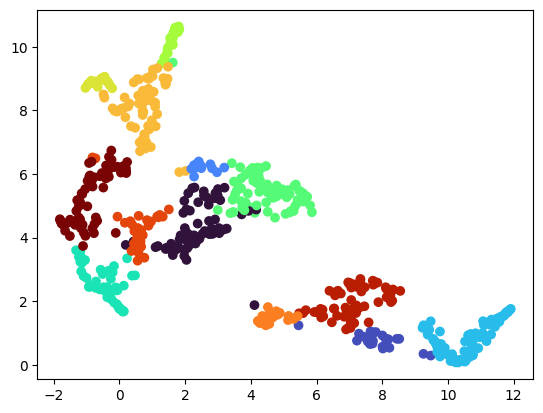

In [21]:
embedding = reducer.fit_transform(normWFs)

import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(normWFs)
umap_df['cluster_id'] = clustering_solution
f,arr = plt.subplots(1);
arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), marker='o', c=umap_df['cluster_id'].tolist(),cmap='turbo')

In [23]:
corners = np.array([
    [-2, 11],  # top-left
    [12, 11],  # top-right
    [-2, 0],  # bottom-left
    [12, 0],  # bottom-right
])

In [24]:
test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)])

In [25]:
inv_transformed_points = reducer.inverse_transform(test_pts)

NameError: name 'cluster_id' is not defined

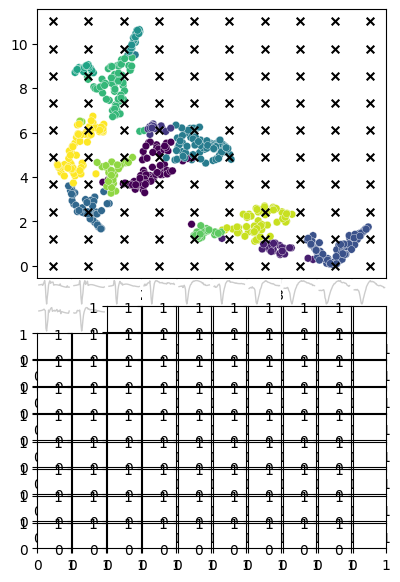

In [35]:
from matplotlib.gridspec import GridSpec

def find_nearest_color(embedding, test_coord, threshold_dist=0.5):
    x_array, y_array = embedding[:,0], embedding[:,1]
    
    # Take coordinates of test point to calculate an array of each point's distance to test then return index
    # where the minimum value is found
    dist_array = np.array(np.abs(x_array-test_coord[0])+np.abs(y_array-test_coord[1]))
    idx = dist_array.argmin()
    
    if dist_array[idx] <= threshold_dist:
        return cluster_id[idx]
    
    else:
        return (0.8,0.8,0.8)
    
fig = plt.figure(figsize=(4.5,7))
gs = GridSpec(20, 10, fig)
gs.update(wspace=0.05, hspace=0.05)
scatter_ax = fig.add_subplot(gs[:10, :10])
waveform_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        waveform_axes[i, j] = fig.add_subplot(gs[10+ i,j])

scatter_ax.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1],
                c=umap_df['cluster_id'], s=30,linewidth=0.25,edgecolor='white',zorder=1)
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', 
                   c='k',
                   s=30, zorder=2, alpha=1)

# Plot each of the generated waveforms
for i in range(10):
    for j in range(10):
        waveform_axes[i, j].plot(inv_transformed_points[i*10 + j], 
                                     c = find_nearest_color(reducer.embedding_,
                                                            test_pts[i*10 + j]),
                                linewidth=1.0)
            
        waveform_axes[i, j].set(xticks=[], yticks=[])
        waveform_axes[i, j].spines['right'].set_visible(False)
        waveform_axes[i, j].spines['top'].set_visible(False)
        waveform_axes[i, j].spines['left'].set_visible(False)
        waveform_axes[i, j].spines['bottom'].set_visible(False)
        
scatter_ax.set(xticks=[], yticks=[])
scatter_ax.spines['right'].set_visible(False)
scatter_ax.spines['top'].set_visible(False)
scatter_ax.spines['left'].set_visible(False)
scatter_ax.spines['bottom'].set_visible(False)